# Orientation vector comparison
Notebook for:
1. creatinon of "fake" orientation vector, starting in (0,0) then moving withevent velocity 
2. comparison to flatten orientatinon vector

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

# loading data
df = {}
event = {}

fname = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC', ]
                                                                            
path = '../datasets/'

for i, x in enumerate(fname):
    df[i]    = pd.read_hdf(path+x+'_filter.h5'           , 'Full' )
    event[i] = pd.read_hdf(path+'analysis/'+x+'_event.h5', 'Event')      
                                                                                                                                    

In [2]:
# in use functions
def angle_zero(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([1     , 0, 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['theta0'] = np.arccos(CosTheta)
    return df

def angle_cos(V1, V2):
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    return CosTheta

def decompose_vec_df(df):
    # get two vectors aligned with Y and Z axes
    Vo = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])  
    Vz = np.array([df.X_Ori, df.Y_Ori, 0       ])  
    Vx = np.array([0       , df.Y_Ori, df.Z_Ori])

    # find the angles between them and orientation vector 
    df['lx1'] = angle_cos(Vo, Vz)
    df['lz1'] = angle_cos(Vo, Vx)
    return df


In [3]:
i = 4
# merge event df with collected data df
dfV = pd.merge(event[i], df[i], on='Frame')

#clearing data off useless variables
dfV.rename(columns={"Time_Ori":'Time'}, inplace=True)
dfV.drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)


## Flattening the orientation vector
To represent the change on XZ - 2D orientation

In [4]:
# calculating lenghts of VecX and VecZ and creation of shifted vectors
dfV = dfV.apply(decompose_vec_df, axis=1)
dfV['V1'] = np.linalg.norm(np.array([dfV.lx1, 0, dfV.lz1]))

# propagate the sign of a X, Z to new vector
dfV['lx1'] = dfV.apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

# normalize the data to unit vector form
dfV['lx1'] = dfV.apply(lambda row: row.lx1 / row.V1, axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 / row.V1, axis=1)

dfV.dropna(inplace=True)

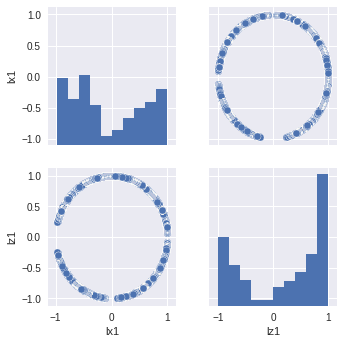

In [5]:
# plot - flattened orientation fo one experiment s
fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['lx1', 'lz1'])

## Creation of event fake orietation vector
New fake orientation vector created. Starting from (1,0) or from original orientation of the animal, vector just in XZ - 2D plane. Looking for similarities in between fake orientation vector and rat's orientation.

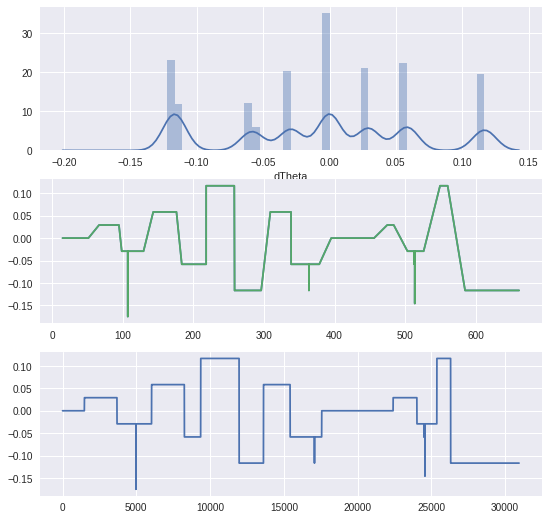

In [ ]:
dfV['dTheta'] = dfV.apply(lambda row: row.dTime * row.speed, axis=1)

dfV = dfV[dfV['dTheta'] < 0.2]
dfV = dfV[dfV['dTheta'] >-0.2]

dftemp = dfV.drop({'MotiveExpTimeSecs', 'lx1', 'lz1', ' Time', 'visible', 'Vxyz', 'V1', 'X_Ori', 'Y_Ori', 'Z_Ori'}, axis=1)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

r = range(0, len(dftemp.Time))

sns.distplot(dftemp.dTheta, ax=ax1)
c2 = ax2.plot(dftemp.Time, dftemp.dTheta)
c2 = ax3.plot(r, dftemp.dTheta)


In [ ]:
#print(dfV.dTheta[1479])
#print(dfV.iloc[1479].dTheta)


X_event, Z_event = [], []
X_event.append(0)
Z_event.append(1)

for ii in range(0, len(dfV.dTheta)-1):
    #alpha = np.radians(dfV.dTheta[ii])
    alpha = np.radians(dfV.iloc[ii].dTheta)
    #alpha = dfV.dTheta[ii]
    
    # calculating each point by rotating orientation vector 
    X, Z = X_event[ii], Z_event[ii]
    #X_new =  X * np.cos(alpha) + Z * np.sin(alpha)
    #Z_new = -X * np.sin(alpha) + Z * np.cos(alpha)
    
    X_new = X * np.cos(alpha) - Z * np.sin(alpha) 
    Z_new = X * np.sin(alpha) + Z * np.cos(alpha)
    
    X_event.append(X_new)
    Z_event.append(Z_new)
    

In [ ]:
dfV['Z_event'] = Z_event
dfV['X_event'] = X_event
fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['Z_event', 'X_event'])

In [ ]:
# fake vector distrubiution and changes in time
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

r = range(0, len(dfV))

sns.distplot(dfV.Z_event, ax=ax1)
sns.distplot(dfV.X_event, ax=ax2) 
c2 = ax3.plot(dfV.Time, dfV.Z_event)
c2 = ax4.plot(dfV.Time, dfV.X_event)

## Comparison of fake vectors vs orientation vector of the animal in XZ 
Methods:
    1. Substracting the X and Z positions and summing it
    2. Comparing the angles
Needs further check, or taking an original orientatino vectors and working with that 

In [ ]:
# X and Z comparison in event and orientation data - after flattening
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

c2 = ax1.plot(dfV.Time, dfV.lx1)
c2 = ax2.plot(dfV.Time, dfV.lz1)
c2 = ax3.plot(dfV.Time, dfV.X_event)
c2 = ax4.plot(dfV.Time, dfV.Z_event)

In [ ]:
dfV['subX']  = dfV.apply(lambda row: row.X_event - row.lx1 , axis=1)
dfV['subZ']  = dfV.apply(lambda row: row.Z_event - row.lz1 , axis=1)
dfV['subXZ'] = dfV.apply(lambda row: row.subZ    + row.subX, axis=1)

In [ ]:
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

c2 = ax1.plot(dfV.Time, dfV.subX)
c2 = ax2.plot(dfV.Time, dfV.subZ)
c2 = ax3.plot(dfV.Time, dfV.subXZ)

# plot in range not in time, to remove filtered time elements 
r = range(0, len(dfV.Time))
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

c2 = ax1.plot(r, dfV.subX)
c2 = ax2.plot(r, dfV.subZ)
c2 = ax3.plot(r, dfV.subXZ)


## Analysis of angle changes in between vectors

In [ ]:
dfV = dfV.apply(angle_zero, axis=1) # calculation with origin

dfV['theta1'] = dfV.theta0.shift(1)
dfV['theta']  = dfV.apply(lambda row: row.theta0 - row.theta1, axis=1)

dfV = dfV[dfV['theta'] < 0.2]
dfV = dfV[dfV['theta'] >-0.2]
dfV['subTheta'] = dfV.apply(lambda row: row.theta - row.dTheta, axis=1)

dfV.drop({'theta0','theta1'}, axis=1, inplace=True)

In [ ]:
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

c2 = ax1.plot(dfV.Time, dfV.theta)
c2 = ax2.plot(dfV.Time, dfV.dTheta)
c2 = ax3.plot(dfV.Time, dfV.subTheta)

# plot in range not in time, to remove filtered time elements 
r = range(0, len(dfV.Time))
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

c2 = ax1.plot(r, dfV.theta)
c2 = ax2.plot(r, dfV.dTheta)
c2 = ax3.plot(r, dfV.subTheta)


## Applying the method for all datasets